## 1. Data Loading and MEPS File Structure

This analysis uses the **MEPS Household Component consolidated person-level file
(HC-251)** for survey year **2023**.

The unit of analysis is the **adult person-year**, where each row corresponds to
one individual observed over a full calendar year. The consolidated file
combines demographic characteristics, insurance coverage, health conditions,
utilization, expenditures, and selected behavioral and mental health measures.

MEPS employs a hybrid variable structure:
- **Annual totals** (e.g., expenditures, utilization) are suffixed by survey year.
- **Health status, mental health, and behavioral variables** are collected in
  specific interview rounds and are round-suffixed.

Understanding this structure is essential before feature selection or modeling.


In [ ]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", 200)

DATA_PATH = "/Users/veerr_89/Work/Projects/Profit-Stabilization-Predictive-Risk-Retention/data_raw/h251.csv"

In [2]:
df_raw = pd.read_csv(DATA_PATH)

print("Raw MEPS shape:", df_raw.shape)
df_raw.head()


Raw MEPS shape: (18919, 1374)


,DUID,PID,DUPERSID,PANEL,DATAYEAR,FAMID31,FAMID42,FAMID53,FAMID23,FAMIDYR,CPSFAMID,FCSZ1231,FCRP1231,RULETR31,RULETR42,RULETR53,RULETR23,RUSIZE31,RUSIZE42,RUSIZE53,RUSIZE23,RUCLAS31,RUCLAS42,RUCLAS53,RUCLAS23,FAMSZE31,FAMSZE42,FAMSZE53,FAMSZE23,FMRS1231,FAMS1231,FAMSZEYR,FAMRFPYR,REGION31,REGION42,REGION53,REGION23,REFPRS31,REFPRS42,REFPRS53,REFPRS23,RESP31,RESP42,RESP53,RESP23,PROXY31,PROXY42,PROXY53,PROXY23,INTVLANG,INTVTYPE31,INTVTYPE42,INTVTYPE53,BEGRFM31,BEGRFY31,ENDRFM31,ENDRFY31,BEGRFM42,BEGRFY42,ENDRFM42,ENDRFY42,BEGRFM53,BEGRFY53,ENDRFM53,ENDRFY53,ENDRFM23,ENDRFY23,KEYNESS,INSCOP31,INSCOP42,INSCOP53,INSCOP23,INSC1231,INSCOPE,ELGRND31,ELGRND42,ELGRND53,ELGRND23,PSTATS31,PSTATS42,PSTATS53,RURSLT31,RURSLT42,RURSLT53,AGE31X,AGE42X,AGE53X,AGE23X,AGELAST,DOBMM,DOBYY,SEX,RACEV1X,RACEV2X,RACEAX,RACEBX,RACEWX,RACETHX,HISPANX,HISPNCAT,...,IPDWCP23,IPDOSR23,IPDPTR23,IPDOTH23,IPNGTD23,DVTOT23,DVTTCH23,DVTEXP23,DVTSLF23,DVTMCR23,DVTMCD23,DVTPRV23,DVTVA23,DVTTRI23,DVTOFD23,DVTSTL23,DVTWCP23,DVTOSR23,DVTPTR23,DVTOTH23,HHTOTD23,HHAGD23,HHATCH23,HHAEXP23,HHASLF23,HHAMCR23,HHAMCD23,HHAPRV23,HHAVA23,HHATRI23,HHAOFD23,HHASTL23,HHAWCP23,HHAOSR23,HHAPTR23,HHAOTH23,HHINDD23,HHNTCH23,HHNEXP23,HHNSLF23,HHNMCD23,HHNMCR23,HHNPRV23,HHNVA23,HHNTRI23,HHNOFD23,HHNSTL23,HHNWCP23,HHNOSR23,HHNPTR23,HHNOTH23,HHINFD23,VISEXP23,VISTCH23,VISSLF23,VISMCR23,VISMCD23,VISPRV23,VISVA23,VISTRI23,VISOFD23,VISSTL23,VISWCP23,VISOSR23,VISPTR23,VISOTH23,OTHTCH23,OTHEXP23,OTHSLF23,OTHMCR23,OTHMCD23,OTHPRV23,OTHVA23,OTHTRI23,OTHOFD23,OTHSTL23,OTHWCP23,OTHOSR23,OTHPTR23,OTHOTH23,RXTOT23,RXEXP23,RXSLF23,RXMCR23,RXMCD23,RXPRV23,RXVA23,RXTRI23,RXOFD23,RXSTL23,RXWCP23,RXOSR23,RXPTR23,RXOTH23,PERWT23F,FAMWT23F,FAMWT23C,SAQWT23F,VARSTR,VARPSU
0,2790002,101,2790002101,27,2023,A,A,A,A,A,A,2,1,A,A,A,A,2,2,2,2,1,1,1,1,2,2,2,2,1,2,2,1,2,2,2,2,101,101,101,101,1,1,1,1,1,1,1,1,1,1,1,1,8,2022,1,2023,1,2023,7,2023,7,2023,12,2023,12,2023,1,1,1,1,1,1,1,1,1,1,1,11,11,11,60,60,60,57,57,58,58,58,8,1965,2,2,2,3,1,3,3,2,9,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,121,39,0,0,82,0,0,0,0,0,0,82,0,11664.426815,11158.817826,11158.817826,13221.315673,2019,1
1,2790002,102,2790002102,27,2023,A,A,A,A,A,A,2,0,A,A,A,A,2,2,2,2,1,1,1,1,2,2,2,2,1,2,2,0,2,2,2,2,101,101,101,101,2,2,2,2,1,1,1,1,1,1,1,1,8,2022,1,2023,1,2023,7,2023,7,2023,12,2023,12,2023,1,1,1,1,1,1,1,1,1,1,1,11,11,11,60,60,60,26,27,27,27,27,6,1996,1,2,2,3,1,3,3,2,9,...,0,0,0,0,0,2,1200,1200,400,0,0,800,0,0,0,0,0,0,800,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,599,350,0,0,0,599,0,0,0,0,0,0,599,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32212.113596,11158.817826,11158.817826,0.000000,2019,1
2,2790004,101,2790004101,27,2023,A,A,A,A,A,A,1,1,A,A,A,A,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,2,2,2,101,101,101,101,1,1,1,1,1,1,1,1,1,1,1,3,10,2022,5,2023,5,2023,9,2023,9,2023,12,2023,12,2023,1,1,1,1,1,1,1,1,1,1,1,11,11,11,60,60,60,48,49,49,49,49,8,1974,2,1,1,3,3,1,2,2,9,...,0,0,0,0,0,1,165,165,10,0,0,155,0,0,0,0,0,0,155,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1575,308,0,0,0,308,0,0,0,0,0,0,308,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21944.142826,28540.745942,28540.745942,29999.277476,2084,1
3,2790006,101,2790006101,27,2023,A,A,A,A,A,A,2,1,A,A,A,A,2,2,2,2,1,1,1,1,2,2,2,2,1,2,2,1,2,2,2,2,101,101,101,101,1,1,1,1,1,1,1,1,1,1,1,1,8,2022,3,2023,3,2023,8,2023,8,2023,12,2023,12,2023,1,1,1,1,1,1,1,1,1,1,1,11,11,11,60,60,60,75,75,75,75,75,2,1948,2,1,1,3,3,1,2,2,9,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,406,121,0,121,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,150,150,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26,758,1,757,0,0,0,0,0,0,0,0,0,0,10328.009530,10821.040689,10821.040689,11144.513916,2113,1
4,2790006,102,2790006102,27,2023,A,A,A,A,A,A,2,0,A,A,A,A,2,2,2,2,1,1,1,1,2,2,2,2,1,2,2,0,2,2,2,2,101,101,101,101,2,2,2,2,1,1,1,1,1,1,1,1,8,2022

In [3]:
df_raw["DATAYEAR"].value_counts(), df_raw["DUPERSID"].nunique()


(DATAYEAR
 2023    18919
 Name: count, dtype: int64,
 18919)

In [4]:
suffix_counts = (
    pd.Series(df_raw.columns)
      .str.extract(r'(\d{2})$')[0]
      .dropna()
      .value_counts()
      .sort_index()
)

suffix_counts


0
17      6
18     12
23    644
31    129
42    209
53     86
Name: count, dtype: int64

### MEPS design implications for this analysis

The HC-251 consolidated file prioritizes **annual utilization and expenditure
measurement**, while behavioral and mental health information is limited to a
small number of interview rounds and variables.

In particular:
- Utilization and expenditure measures are comprehensive and year-complete.
- Behavioral indicators are sparse and limited to smoking and exercise frequency.
- Mental health and functional limitation variables are richer but round-specific.

As a result, feature selection must be driven by **observed availability**, not
assumed survey coverage.


In [5]:
print("Total columns:", df_raw.shape[1])

# Rough grouping by prefix (diagnostic only)
prefix_sample = pd.Series([c[:3] for c in df_raw.columns]).value_counts().head(10)
prefix_sample


Total columns: 1374


PRI    44
MCR    37
MCD    35
INS    28
TRI    27
GOV    24
PUB    22
OTH    20
VAP    20
IHS    20
Name: count, dtype: int64

## 3. Reduced Feature Selection (Final Schema)

This section constructs the final reduced-feature dataset used for all EDA and
preprocessing. Based on Sections 1–2, we retain a minimal, policy-relevant set of
variables spanning demographics, socioeconomic status, insurance coverage,
behavior, mental health, functional limitations, utilization, and expenditures.

Design principles:
- One construct → one round (latest available where applicable)
- Annual totals only for utilization and expenditures
- No payer splits or service subcomponents
- Explicit exclusion of unavailable behavioral variables


In [6]:
id_vars = [
    "DUPERSID", "PANEL", "DATAYEAR"
]

weight_vars = [
    "PERWT23F", "VARSTR", "VARPSU"
]


In [7]:
demo_vars = [
    "AGELAST",
    "SEX",
    "RACETHX",
    "HISPANX",
    "EDUCYR",
    "MARRY53X"
]


In [8]:
ses_vars = [
    "FAMINC23",
    "POVCAT23",
    "TTLP23X",
    "EMPST53"
]


In [9]:
insurance_vars = [
    "INSURC23",
    "PRVEV23",
    "MCREV23",
    "MCDEV23",
    "UNINS23"
]


In [10]:
clinical_vars = [
    "HIBPDX",        # hypertension
    "DIABDX_M18",    # diabetes
    "CHDDX",         # coronary heart disease
    "MIDX",          # myocardial infarction
    "STRKDX",        # stroke
    "EMPHDX",        # COPD/emphysema
    "CHOLDX",        # high cholesterol
    "ARTHDX",        # arthritis
    "ASTHDX",        # asthma
    "CANCERDX",      # any cancer
    "ANYLMI23",      # any mental illness
    "COVIDEVER53"   # ever COVID diagnosis
]


In [11]:
behavior_vars = [
    "PHYEXE53",   # exercise frequency
    "OFTSMK53"    # smoking frequency
]


In [12]:
mental_vars = [
    "RTHLTH53",   # self-rated physical health
    "MNHLTH53",   # self-rated mental health
    "K6SUM42",    # psychological distress
    "PHQ242"      # depression screener
]


In [13]:
function_vars = [
    "ADLHLP31",
    "IADLHP31",
    "WLKLIM31",
    "COGLIM31",
    "WRKLIM31",
    "SOCLIM31"
]


In [14]:
util_vars = [
    "OBTOTV23",   # office visits
    "OPTOTV23",   # outpatient visits
    "ERTOT23",    # ER visits
    "IPDIS23",    # inpatient discharges
    "RXTOT23"     # prescription fills
]

target_vars = [
    "TOTEXP23"    # total annual expenditure
]


In [15]:
final_vars = (
    id_vars
    + weight_vars
    + demo_vars
    + ses_vars
    + insurance_vars
    + clinical_vars
    + behavior_vars
    + mental_vars
    + function_vars
    + util_vars
    + target_vars
)

len(final_vars), final_vars


(51,
 ['DUPERSID',
  'PANEL',
  'DATAYEAR',
  'PERWT23F',
  'VARSTR',
  'VARPSU',
  'AGELAST',
  'SEX',
  'RACETHX',
  'HISPANX',
  'EDUCYR',
  'MARRY53X',
  'FAMINC23',
  'POVCAT23',
  'TTLP23X',
  'EMPST53',
  'INSURC23',
  'PRVEV23',
  'MCREV23',
  'MCDEV23',
  'UNINS23',
  'HIBPDX',
  'DIABDX_M18',
  'CHDDX',
  'MIDX',
  'STRKDX',
  'EMPHDX',
  'CHOLDX',
  'ARTHDX',
  'ASTHDX',
  'CANCERDX',
  'ANYLMI23',
  'COVIDEVER53',
  'PHYEXE53',
  'OFTSMK53',
  'RTHLTH53',
  'MNHLTH53',
  'K6SUM42',
  'PHQ242',
  'ADLHLP31',
  'IADLHP31',
  'WLKLIM31',
  'COGLIM31',
  'WRKLIM31',
  'SOCLIM31',
  'OBTOTV23',
  'OPTOTV23',
  'ERTOT23',
  'IPDIS23',
  'RXTOT23',
  'TOTEXP23'])

In [16]:
df_reduced = df_raw[final_vars].copy()

df_reduced.shape


(18919, 51)

In [17]:
# Missingness overview
missing_summary = (
    df_reduced
    .isna()
    .mean()
    .sort_values(ascending=False)
)

missing_summary.head(10)


DUPERSID       0.0
PHQ242         0.0
ARTHDX         0.0
ASTHDX         0.0
CANCERDX       0.0
ANYLMI23       0.0
COVIDEVER53    0.0
PHYEXE53       0.0
OFTSMK53       0.0
RTHLTH53       0.0
dtype: float64

## 4. Exploratory Analysis I: Cost and Utilization Structure

This section explores the distribution of annual health-care expenditures and
utilization in the reduced MEPS 2023 dataset. The goal is to understand baseline
cost concentration, utilization intensity, and natural separation between
low-risk and high-risk individuals before any modeling assumptions are imposed.


In [18]:
df_reduced["TOTEXP23"].describe(percentiles=[0.5, 0.75, 0.9, 0.95, 0.99])


count     18919.000000
mean       8422.054125
std       21664.250470
min           0.000000
50%        1816.000000
75%        7087.000000
90%       20883.400000
95%       37686.400000
99%       98447.080000
max      574675.000000
Name: TOTEXP23, dtype: float64

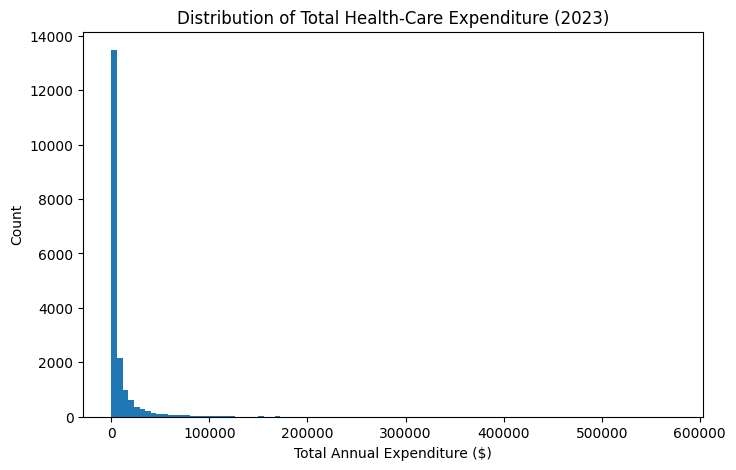

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(df_reduced["TOTEXP23"], bins=10)
plt.xlabel("Total Annual Expenditure ($)")
plt.ylabel("Count")
plt.title("Distribution of Total Health-Care Expenditure (2023)")
plt.show()


In [20]:
df_reduced["LOG_TOTEXP23"] = np.log1p(df_reduced["TOTEXP23"])

df_reduced["LOG_TOTEXP23"].describe()


count    18919.000000
mean         6.719749
std          3.179962
min          0.000000
25%          5.705446
50%          7.504942
75%          8.866158
max         13.261562
Name: LOG_TOTEXP23, dtype: float64

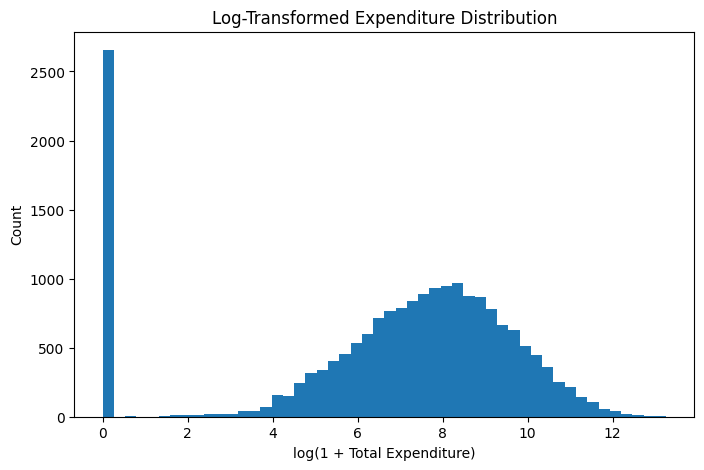

In [21]:
plt.figure(figsize=(8, 5))
plt.hist(df_reduced["LOG_TOTEXP23"], bins=50)
plt.xlabel("log(1 + Total Expenditure)")
plt.ylabel("Count")
plt.title("Log-Transformed Expenditure Distribution")
plt.show()


In [22]:
df_reduced["CATA_10K"] = (df_reduced["TOTEXP23"] >= 10_000).astype(int)
df_reduced["CATA_20K"] = (df_reduced["TOTEXP23"] >= 20_000).astype(int)

df_reduced[["CATA_10K", "CATA_20K"]].mean()


CATA_10K    0.193615
CATA_20K    0.104551
dtype: float64

In [23]:
util_zero_rates = (df_reduced[["OBTOTV23", "OPTOTV23", "ERTOT23", "IPDIS23", "RXTOT23"]] == 0).mean()

util_zero_rates


OBTOTV23    0.260373
OPTOTV23    0.741741
ERTOT23     0.847191
IPDIS23     0.925947
RXTOT23     0.373223
dtype: float64

In [24]:
df_reduced.groupby("ERTOT23")["TOTEXP23"].median().head(10)


ERTOT23
0     1271.5
1     7656.0
2    14964.0
3    23164.5
4    36557.0
5    30745.0
6    49521.5
7    71043.0
8    52977.0
9    35451.0
Name: TOTEXP23, dtype: float64

In [25]:
p30 = df_reduced["TOTEXP23"].quantile(0.30)

df_reduced["LOW_RISK_PROTO"] = (
    (df_reduced["TOTEXP23"] <= p30) &
    (df_reduced["ERTOT23"] == 0) &
    (df_reduced["IPDIS23"] == 0)
).astype(int)

df_reduced["LOW_RISK_PROTO"].mean()


np.float64(0.2948887361911306)

In [26]:
top_10_share = (
    df_reduced
    .sort_values("TOTEXP23", ascending=False)
    .head(int(0.10 * len(df_reduced)))["TOTEXP23"]
    .sum()
    / df_reduced["TOTEXP23"].sum()
)

top_10_share


np.float64(0.6381832520566713)

## 5. Exploratory Analysis II: Behavior, Mental Health, and Functional Limitations

This section examines whether behavioral indicators, mental health measures, and
functional limitations differentiate low-risk individuals from the rest of the
population. The analysis is descriptive and intended to identify signal strength
and directional patterns prior to any predictive modeling.


In [27]:
p30 = df_reduced["TOTEXP23"].quantile(0.30)

df_reduced["LOW_RISK_PROTO"] = (
    (df_reduced["TOTEXP23"] <= p30) &
    (df_reduced["ERTOT23"] == 0) &
    (df_reduced["IPDIS23"] == 0)
).astype(int)

df_reduced["LOW_RISK_PROTO"].mean()


np.float64(0.2948887361911306)

In [28]:
behavior_summary = (
    df_reduced
    .groupby("LOW_RISK_PROTO")[["PHYEXE53", "OFTSMK53"]]
    .mean()
)

behavior_summary


,PHYEXE53,OFTSMK53
LOW_RISK_PROTO,,
0,1.012369,2.134033
1,0.535938,1.472128


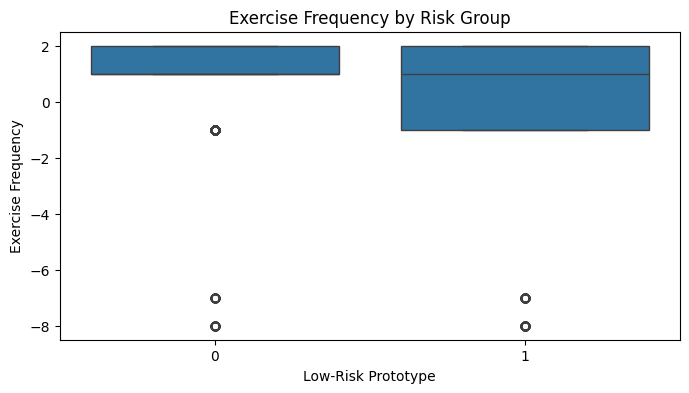

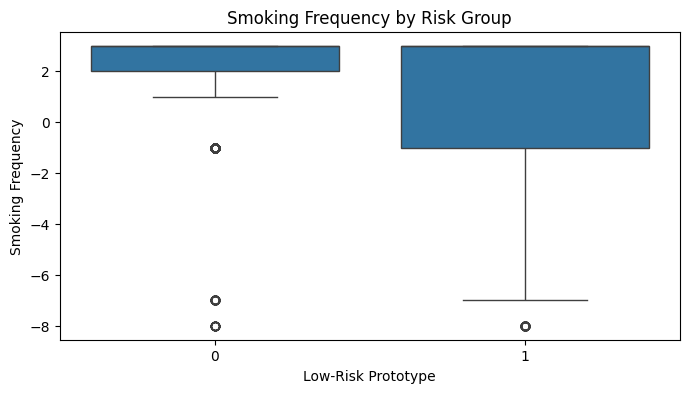

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.boxplot(
    data=df_reduced,
    x="LOW_RISK_PROTO",
    y="PHYEXE53"
)
plt.title("Exercise Frequency by Risk Group")
plt.xlabel("Low-Risk Prototype")
plt.ylabel("Exercise Frequency")
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(
    data=df_reduced,
    x="LOW_RISK_PROTO",
    y="OFTSMK53"
)
plt.title("Smoking Frequency by Risk Group")
plt.xlabel("Low-Risk Prototype")
plt.ylabel("Smoking Frequency")
plt.show()


In [30]:
mental_summary = (
    df_reduced
    .groupby("LOW_RISK_PROTO")[["RTHLTH53", "MNHLTH53", "K6SUM42", "PHQ242"]]
    .mean()
)

mental_summary


,RTHLTH53,MNHLTH53,K6SUM42,PHQ242
LOW_RISK_PROTO,,,,
0,2.384933,2.249325,1.138531,-0.302474
1,1.958774,1.944434,-0.151461,-0.731314


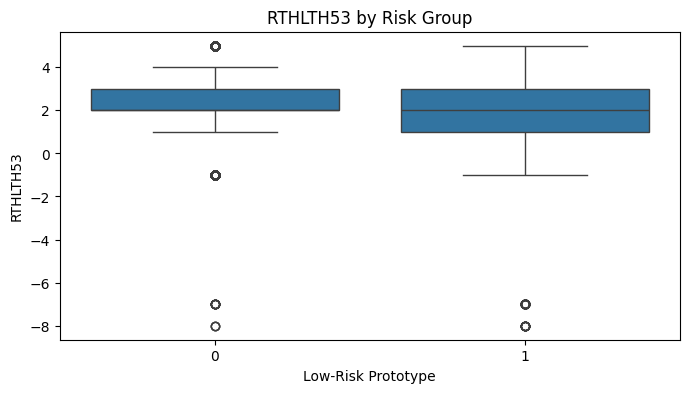

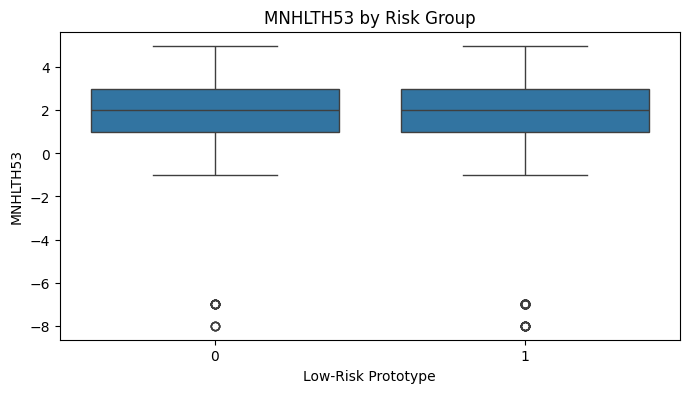

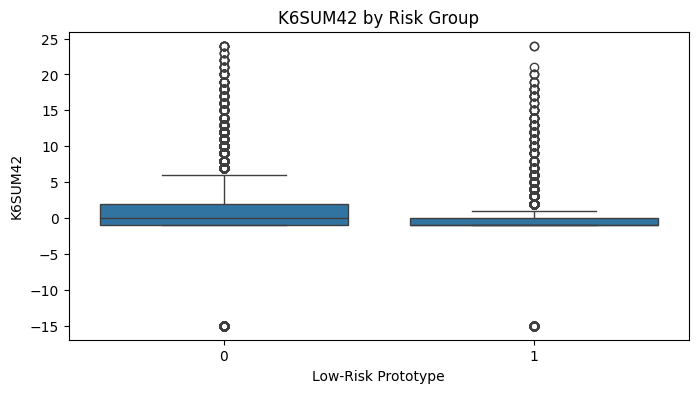

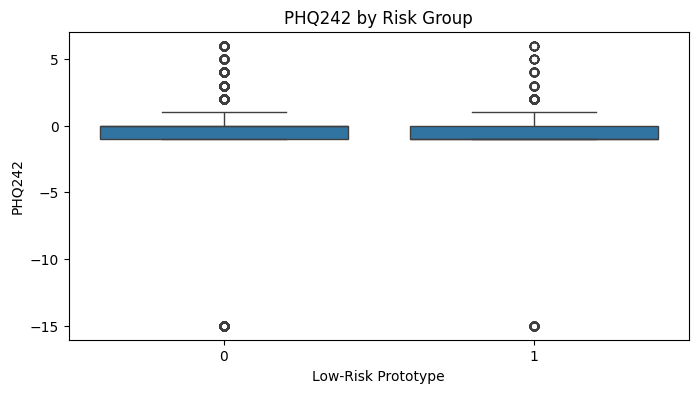

In [31]:
mental_vars = ["RTHLTH53", "MNHLTH53", "K6SUM42", "PHQ242"]

for v in mental_vars:
    plt.figure(figsize=(8, 4))
    sns.boxplot(
        data=df_reduced,
        x="LOW_RISK_PROTO",
        y=v
    )
    plt.title(f"{v} by Risk Group")
    plt.xlabel("Low-Risk Prototype")
    plt.ylabel(v)
    plt.show()


In [32]:
function_cols = [
    "ADLHLP31", "IADLHP31", "WLKLIM31",
    "COGLIM31", "WRKLIM31", "SOCLIM31"
]

function_rates = (
    df_reduced
    .groupby("LOW_RISK_PROTO")[function_cols]
    .mean()
)

function_rates


,ADLHLP31,IADLHP31,WLKLIM31,COGLIM31,WRKLIM31,SOCLIM31
LOW_RISK_PROTO,,,,,,
0,1.926912,1.899475,1.790180,1.408921,-0.754723,1.862594
1,1.875426,1.864313,1.847105,1.023839,-0.972755,1.865567


In [33]:
df_reduced["LIMIT_CT"] = df_reduced[function_cols].sum(axis=1)

df_reduced.groupby("LOW_RISK_PROTO")["LIMIT_CT"].describe()


,count,mean,std,min,25%,50%,75%,max
LOW_RISK_PROTO,,,,,,,,
0,13340.0,8.133358,2.681394,-43.0,8.0,9.0,9.0,12.0
1,5579.0,7.503495,3.522012,-43.0,6.0,9.0,9.0,12.0


In [34]:
# Recode functional limitation variables to binary
func_binary = {}

for c in function_cols:
    func_binary[c] = (
        df_reduced[c]
        .replace({-9: np.nan, -8: np.nan, -7: np.nan})
        .map({1: 1, 2: 0})
    )

df_func = pd.DataFrame(func_binary)

df_reduced["LIMIT_CT"] = df_func.sum(axis=1)

df_reduced.groupby("LOW_RISK_PROTO")["LIMIT_CT"].describe()


,count,mean,std,min,25%,50%,75%,max
LOW_RISK_PROTO,,,,,,,,
0,13340.0,0.50015,1.129948,0.0,0.0,0.0,0.0,6.0
1,5579.0,0.07349,0.443241,0.0,0.0,0.0,0.0,6.0


<Axes: xlabel='LOW_RISK_PROTO', ylabel='PHQ242'>

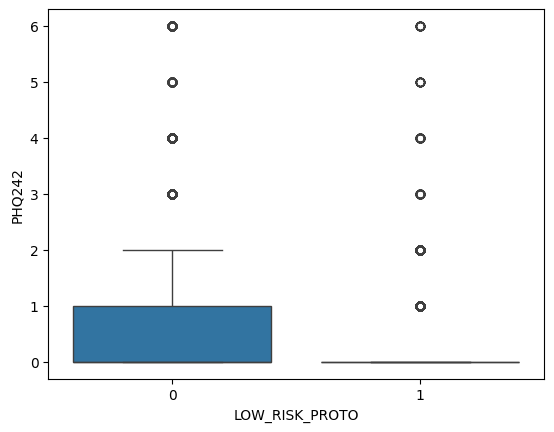

In [35]:
sns.boxplot(
    data=df_reduced[df_reduced[v] >= 0],
    x="LOW_RISK_PROTO",
    y=v
)


## 6. Preprocessing & Feature Engineering

This section converts the reduced MEPS dataset into a model-ready table by:
- Cleaning MEPS-coded missing values
- Recoding categorical variables
- Engineering compact clinical and functional summaries
- Finalizing risk labels
- Exporting a single CSV for downstream modeling

All transformations are deterministic and documented to ensure reproducibility.


In [36]:
MEPS_MISS = [-7, -8, -9]

df_prep = df_reduced.replace(MEPS_MISS, np.nan).copy()


In [37]:
binary_dx = [
    "HIBPDX", "DIABDX_M18", "CHDDX", "MIDX", "STRKDX",
    "EMPHDX", "CHOLDX", "ARTHDX", "ASTHDX", "CANCERDX",
    "ANYLMI23", "COVIDEVER53"
]

for c in binary_dx:
    df_prep[c] = (
        df_prep[c]
        .map({1: 1, 2: 0})
        .fillna(0)
    )



In [38]:
df_prep["CHRONIC_CT"] = df_prep[binary_dx].sum(axis=1)

df_prep["CHRONIC_CT"].describe()


count    18919.000000
mean         2.049051
std          1.911490
min          0.000000
25%          1.000000
50%          1.000000
75%          3.000000
max         12.000000
Name: CHRONIC_CT, dtype: float64

In [39]:
function_cols = [
    "ADLHLP31", "IADLHP31", "WLKLIM31",
    "COGLIM31", "WRKLIM31", "SOCLIM31"
]

# Recode functional limitation variables to binary
for c in function_cols:
    df_prep[c] = (
        df_prep[c]
        .map({1: 1, 2: 0})
        .fillna(0)   # treat missing as no limitation
    )

df_prep["LIMIT_CT"] = df_prep[function_cols].sum(axis=1)



In [40]:
behavior_vars = ["PHYEXE53", "OFTSMK53"]

# Behavioral variables: median imputation only
for c in behavior_vars:
    df_prep[c] = df_prep[c].fillna(df_prep[c].median())



In [41]:
from sklearn.preprocessing import OrdinalEncoder

cat_vars = [
    "SEX", "RACETHX", "HISPANX",
    "EDUCYR", "MARRY53X",
    "INSURC23", "EMPST53", "POVCAT23"
]

encoder = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1
)

df_prep[cat_vars] = encoder.fit_transform(df_prep[cat_vars])



In [42]:
# Low expenditure indicator
df_prep["LOW_SPEND"] = (
    df_prep["TOTEXP23"] <= df_prep["TOTEXP23"].quantile(0.30)
).astype(int)

# Stable low-risk label
df_prep["LOW_RISK"] = (
    (df_prep["LOW_SPEND"] == 1) &
    (df_prep["ERTOT23"] == 0) &
    (df_prep["IPDIS23"] == 0)
).astype(int)

# Catastrophic risk flags
df_prep["CATA_10K"] = (df_prep["TOTEXP23"] >= 10_000).astype(int)
df_prep["CATA_20K"] = (df_prep["TOTEXP23"] >= 20_000).astype(int)

df_prep[["LOW_RISK", "CATA_10K", "CATA_20K"]].mean()


LOW_RISK    0.294889
CATA_10K    0.193615
CATA_20K    0.104551
dtype: float64

In [43]:
exclude_from_X = [
    "DUPERSID", "PANEL", "DATAYEAR",
    "PERWT23F", "VARSTR", "VARPSU"
]

model_features = [
    c for c in df_prep.columns
    if c not in exclude_from_X
]

len(model_features)


53

In [44]:
df_prep[model_features].isna().mean().sort_values(ascending=False).head(10)


EMPST53     0.009356
EDUCYR      0.008827
MNHLTH53    0.003330
RTHLTH53    0.003277
MARRY53X    0.001110
OPTOTV23    0.000000
K6SUM42     0.000000
PHQ242      0.000000
ADLHLP31    0.000000
IADLHP31    0.000000
dtype: float64

In [45]:
df_prep[
    function_cols + behavior_vars + cat_vars
].isna().mean().sort_values(ascending=False)


EMPST53     0.009356
EDUCYR      0.008827
MARRY53X    0.001110
ADLHLP31    0.000000
IADLHP31    0.000000
WLKLIM31    0.000000
COGLIM31    0.000000
WRKLIM31    0.000000
SOCLIM31    0.000000
PHYEXE53    0.000000
OFTSMK53    0.000000
SEX         0.000000
RACETHX     0.000000
HISPANX     0.000000
INSURC23    0.000000
POVCAT23    0.000000
dtype: float64

In [46]:
OUTPUT_PATH = (
    "/Users/veerr_89/Work/Projects/"
    "Profit-Stabilization-Predictive-Risk-Retention/"
    "data_processed/meps_model_ready_2023.csv"
)

df_prep.to_csv(OUTPUT_PATH, index=False)

OUTPUT_PATH


'/Users/veerr_89/Work/Projects/Profit-Stabilization-Predictive-Risk-Retention/data_processed/meps_model_ready_2023.csv'

## EDA + Preprocessing Brief Aligned to the Research Question

### Research question

Can low-risk health-care members be reliably identified using a reduced, behavior-oriented feature set, and what is the minimum predictive structure needed to stabilize cost-risk segmentation under uncertainty?

---

## 1) What the data structure implies for “minimal, behavior-oriented” modeling

MEPS 2023 (HC-251) is high-dimensional but structurally heterogeneous: annual totals are year-suffixed (`…23`) while many health status and psychosocial measures are round-suffixed (`31/42/53`). This matters because it constrains what “behavior-oriented” can mean in 2023: the consolidated file contains only two adult behavioral indicators (`PHYEXE53`, `OFTSMK53`). BMI/diet/alcohol are not available in this release. As a result, any “behavior-only” identification strategy in 2023 must be interpreted as “behavior signal under realistic data availability,” not as an exhaustive lifestyle model.

**Implication:** the project’s “reduced feature” mandate is naturally satisfied by the data; the key scientific question becomes whether this sparse behavior signal is sufficient on its own, or whether stable segmentation requires adding compact structural domains (mental health, functional limits, chronic burden, utilization).

---

## 2) Cost risk in MEPS is dominated by tail behavior (why segmentation is necessary)

Annual total expenditure (`TOTEXP23`) is extremely right-skewed: the bulk of members have low-to-moderate spending, while a small fraction accounts for very large costs. This is reflected in (i) large gaps between median and mean spending and (ii) extreme upper quantiles and maxima. Log-transforming `TOTEXP23` produces a more stable, approximately unimodal distribution for exploratory purposes, confirming that raw cost is heavy-tailed and that “typical risk” and “tail risk” behave differently.

Two catastrophic flags (`≥$10k`, `≥$20k`) show that tail risk is not negligible; a meaningful minority of members crosses these thresholds. In actuarial terms, this means segmentation must explicitly address the tail—not just average cost—and that model stability should be evaluated by how sensitive predictions are to rare, high-cost realizations.

**Implication:** “low-risk” is best defined not only by low spend but also by avoidance of acute utilization events that are strongly associated with tail outcomes.

---

## 3) Utilization is strongly zero-inflated and tightly linked to spending

Utilization totals (`ERTOT23`, `IPDIS23`, `OBTOTV23`, `OPTOTV23`, `RXTOT23`) show substantial zero mass—especially for ER and inpatient events—indicating that many members have no acute care utilization in a year. This creates a natural structural split in the population: “no acute events” versus “any acute event,” with the latter aligning with large jumps in median expenditure.

In particular, median spending rises sharply even for small counts of ER visits. This is consistent with an actuarial interpretation that acute utilization functions as a strong proxy for severity shocks or destabilizing health events. As a result, utilization is not merely a correlate of cost; it is part of the minimal risk structure that stabilizes segmentation.

**Implication:** if the goal is stable low-risk identification under uncertainty, “no ER and no inpatient” should be treated as a key stabilizing condition and an important feature block.

---

## 4) A conservative “low-risk prototype” is identifiable and interpretable

An EDA-driven low-risk prototype was constructed using a percentile-based low-spend rule (bottom ~30% of `TOTEXP23`) plus zero acute utilization (no ER visits and no inpatient discharges). This definition produces a sizable but conservative low-risk pool suitable for supervised learning and group contrast analysis. It is explicitly a labeling heuristic—not a latent truth—and is used to discover which reduced features differentiate stable low spenders from the rest.

**Implication:** the prototype definition operationalizes “stability” in a way that aligns with the project’s retention/profit-stabilization motivation (low cost + low volatility drivers), setting up downstream tests of predictive structure and robustness.

---

## 5) Behavior signal exists, but it is sparse and unlikely to be sufficient alone

Within the available 2023 consolidated-file behavior set (exercise and smoking frequency), there are clear directional differences between the low-risk prototype and others. This suggests behavior has measurable association with stable low-cost status even when defined conservatively.

However, because the behavioral block is limited to two ordinal variables in this file, the EDA implies that behavior alone is unlikely to fully stabilize segmentation under uncertainty. Behavior contributes signal, but it does not capture latent clinical severity, functional impairment, or psychosocial distress that can drive utilization shocks and tail costs.

**Implication:** the “behavior-only” model is expected to be a useful baseline but not the minimal stable structure; stability likely requires adding at least one compact structural block.

---

## 6) Mental health and distress measures add strong differentiating signal

Self-rated health (`RTHLTH53`, `MNHLTH53`) and psychological distress/depression screens (`K6SUM42`, `PHQ242`) show pronounced separation between low-risk and non-low-risk members. This indicates that mental health is not a marginal add-on; it likely provides predictive value beyond behavior and can help explain risk among members with similar utilization in the current year.

From a segmentation perspective, psychosocial variables may function as “early warning” signals for future destabilization (e.g., worsening adherence, increased acute episodes), which is directly relevant to the project’s emphasis on stability.

**Implication:** a minimal structure that stabilizes segmentation may require combining behavior with mental health measures, especially when the behavioral block is sparse.

---

## 7) Functional limitations are rare in low-risk and serve as structural risk markers

After proper recoding of MEPS limitation variables to binary indicators and construction of a limitation count (`LIMIT_CT`), functional limitations are substantially less prevalent in the low-risk prototype than in the remainder of the population. This supports the idea that functional status captures persistent, structural risk that is not fully explained by behavior and may not be captured by one-year utilization totals alone.

**Implication:** adding a compact functional limitation summary (e.g., `LIMIT_CT`) is a strong candidate for the minimal stabilizing structure because it is interpretable, low-dimensional, and strongly aligned with persistent elevated risk.

---

## 8) Clinical burden can be compressed into a stable low-dimensional signal

Chronic condition flags were recoded into binary and summarized into `CHRONIC_CT`. The distribution suggests many adults have low-to-moderate burden, with a long tail indicating a subset with multi-morbidity. This clinical burden summary provides an interpretable and compact representation of underlying health status and is a likely stabilizer for risk segmentation, particularly in distinguishing stable low-risk members from “quiet risk” individuals who have low current-year utilization but substantial chronic burden.

**Implication:** `CHRONIC_CT` is a natural component of a minimal predictive structure because it is robust, easy to report, and captures persistent severity.

---

## 9) What the EDA suggests about the “minimum predictive structure”

Based on observed separation patterns, the EDA supports the following hypothesis about minimal structure, ordered from weakest to strongest stability:

1. **Behavior-only (exercise + smoking):** detectable signal, likely insufficient for stable segmentation.
2. **Behavior + mental health:** materially stronger; adds psychosocial risk gradients.
3. **+ functional limitation summary:** large gain in structural separation; likely stabilizes segmentation across uncertainty.
4. **+ clinical burden count:** captures persistent disease load and “quiet risk.”
5. **+ utilization totals:** strongest contemporaneous segmentation but may partially reflect outcomes rather than upstream risk; should be tested carefully for stability and interpretability.

This hierarchy directly operationalizes the research question: stability is expected to emerge not from adding many variables, but from adding a small number of high-signal domains that represent different causal layers (behavior → psychosocial/functional → chronic burden → utilization → cost).

---

## 10) Key takeaway

The EDA indicates that low-risk members can be defined in a conservative, operational way and that they exhibit consistent differences across behavior, mental health, functional status, and clinical burden. The behavioral block available in MEPS 2023 is limited but informative; however, stable cost-risk segmentation under uncertainty likely requires a minimal multi-domain structure—most plausibly behavior plus a compact mental health and functional/clinical burden summary—rather than behavior alone.

This sets up the modeling phase to explicitly test:

* predictive accuracy and calibration,
* feature ablation and “collapse” under reduced structures,
* bootstrap stability of segment membership,
* robustness of the low-risk segment definition to threshold variation.
